In [1]:
# Python library imports: numpy, random, sklearn, pandas, etc

import warnings
warnings.filterwarnings('ignore')

import sys
import random
import numpy as np

# cross_validation is deprecated since version 0.18. This module will be removed in 0.20.
# Use sklearn.model_selection.train_test_split instead.
# from sklearn import linear_model, cross_validation, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics, svm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
# function to read HDFS file into dataframe using PyDoop
import pydoop.hdfs as hdfs
def read_csv_from_hdfs(path, cols, col_types=None):
    files = hdfs.ls(path);
    pieces = []
    for f in files:
        fhandle = hdfs.open(f)
        pieces.append(pd.read_csv(fhandle, names=cols, dtype=col_types, skiprows=1))
        fhandle.close()
    return pd.concat(pieces, ignore_index=True)

## Perform analysis flight data

In [56]:
# Load data and get the shape of the dataframe
# cols = ['year', 'month', 'day', 'dow', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'Carrier', 'FlightNum', 
#         'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 
#         'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay', 
#         'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'];
columns = ['year', 'month', 'day_of_month', 'day_of_week', 'dep_time', 'crs_dep_time', 'arr_time', 'crs_arr_time', 'unique_carrier', 'flight_num', 'tail_num',
           'actual_elapsed_time', 'crs_elapsed_time', 'air_time', 'arr_delay', 'dep_delay', 'origin', 'dest', 'distance', 'taxi_in', 'taxi_out','cancelled',
           'cancellation_code', 'diverted', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']

PROCESSING_FILE_NAME = '1996.csv'
processing_file_name = f"./result/{PROCESSING_FILE_NAME}"
flight_df = read_csv_from_hdfs(processing_file_name, cols)

flight_df.shape

(5034804, 29)

In [47]:
flight_df.head()

,year,month,day,dow,DepTime,CRSDepTime,ArrTime,CRSArrTime,Carrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1996,1,29,1,1996-01-29 20:39:00,1996-01-29 19:30:00,1996-01-29 22:45:00,1996-01-29 21:39:00,DL,345,...,6,10,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1996,1,30,2,1996-01-30 19:31:00,1996-01-30 19:30:00,1996-01-30 21:42:00,1996-01-30 21:39:00,DL,345,...,5,22,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,1996,1,31,3,1996-01-31 19:56:00,1996-01-31 19:30:00,1996-01-31 22:31:00,1996-01-31 21:39:00,DL,345,...,7,27,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,1996,1,1,1,1996-01-01 17:30:00,1996-01-01 15:50:00,1996-01-01 19:09:00,1996-01-01 17:45:00,DL,411,...,4,14,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,1996,1,2,2,1996-01-02 17:14:00,1996-01-02 15:50:00,1996-01-02 18:41:00,1996-01-02 17:45:00,DL,411,...,4,8,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Let see some flight statistics
Let's look at some basic statistics, after limiting ourselves to flights originating from ORD

In [57]:
# Convert dataframe to correct type
flight_df.columns

def convert_df_types(dataframe):
    dataframe['cancelled'] = dataframe['Cancelled'].astype(bool)
    dataframe['Diverted'] = dataframe['Diverted'].astype(bool)
    dataframe['DepDelay'] = dataframe['DepDelay'].astype(int)
#     dataframe["DepDelay"] = pd.to_numeric(dataframe["DepDelay"], downcast='float')
    
convert_df_types(flight_df)
# flight_df.head()
flight_df['DepDelay']

0           69
1            1
2           26
3          100
4           84
          ... 
5034799      1
5034800      9
5034801     -1
5034802     59
5034803     82
Name: DepDelay, Length: 5034804, dtype: int64

In [58]:
# 
df = flight_df[flight_df['Origin']=='ORD'].dropna(subset=['DepDelay'])
df['DepDelayed'] = df['DepDelay'].apply(lambda x: x>=15)
print("total flights: " + str(df.shape[0]))
print("total delays: " + str(df['DepDelayed'].sum()))

total flights: 264436
total delays: 57183


#### how delayed flights are distributed by month

<Axes: xlabel='month'>

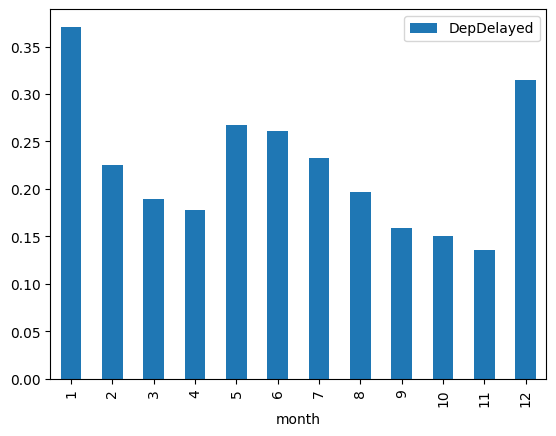

In [52]:
# Select a Pandas dataframe with flight originating from ORD

# Compute average number of delayed flights per month
grouped = df[['DepDelayed', 'month']].groupby('month').mean()

# plot average delays by month
grouped.plot(kind='bar')

We see that the average number of delays is highest in December and February, which is what we would expect

#### Delay by the hour-of-day

<Axes: xlabel='hour'>

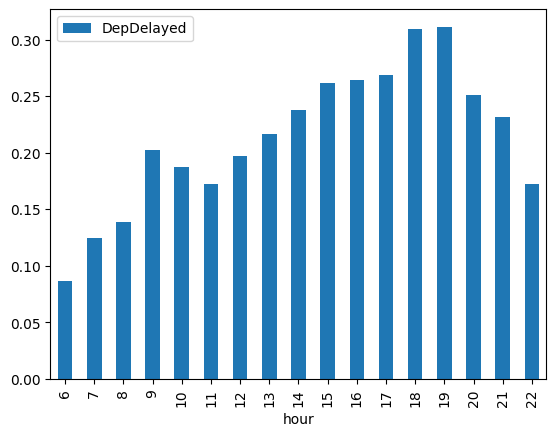

In [62]:
from datetime import datetime

# Compute average number of delayed flights by hour
def convert_str_to_hour(datetime_str):
    date_obj = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')
    
    return date_obj.hour

df['hour'] = df['CRSDepTime'].map(convert_str_to_hour)
grouped = df[['DepDelayed', 'hour']].groupby('hour').mean()

# plot average delays by hour of day
grouped.plot(kind='bar')
# df['hour']

A clear pattern here - flights tend to be delayed later in the day. Perhaps this is because delays tend to pile up as the day progresses and the problem tends to compound later in the day.

#### Delay by carrier

<Axes: xlabel='Carrier'>

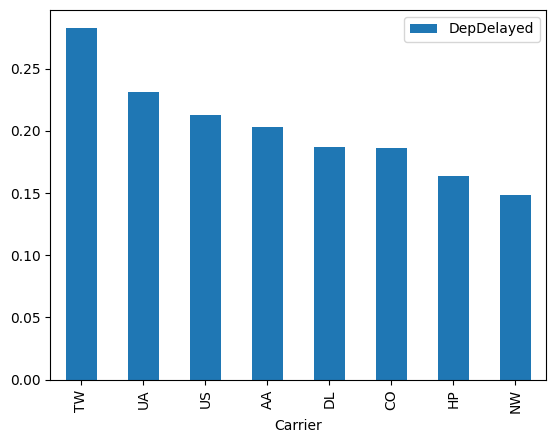

In [64]:
# Compute average number of delayed flights per carrier
grouped1 = df[['DepDelayed', 'Carrier']].groupby('Carrier').filter(lambda x: len(x)>10)
grouped2 = grouped1.groupby('Carrier').mean()
carrier = grouped2.sort_values(['DepDelayed'], ascending=False)

# display top 15 destination carriers by delay (from ORD)
carrier[:15].plot(kind='bar')

some airlines are better than others.

## Pre-processing: using Hadoop to build a feature matrix

In [1]:
# Execute the script directly from IPython (the Python UDFs are separately stored in "util.py")
%%writefile preprocess1.pig

Register 'util.py' USING jython as util;
DEFINE preprocess(year_str, airport_code) returns data
{
        -- load airline data from specified year (need to specify fields since it's not in HCat)
        airline = load './result/$year_str.csv' using PigStorage(',') 
            as (Year: int, Month: int, DayOfMonth: int, DayOfWeek: int, DepTime: chararray, 
                CRSDepTime: chararray, ArrTime, CRSArrTime, Carrier: chararray, FlightNum, TailNum, ActualElapsedTime, 
                CRSElapsedTime, AirTime, ArrDelay, DepDelay: int, Origin: chararray, Dest: chararray, Distance: int, 
                TaxiIn, TaxiOut, Cancelled: int, CancellationCode, Diverted, CarrierDelay, WeatherDelay, 
                NASDelay, SecurityDelay, LateAircraftDelay);

        -- keep only instances where flight was not cancelled and originate at ORD
        airline_flt = filter airline by Cancelled == 0 and Origin == '$airport_code';

        -- Keep only fields I need
        $data = foreach airline_flt generate DepDelay as delay, Month, DayOfMonth, DayOfWeek, 
                                             util.get_hour(CRSDepTime) as hour, Distance, Carrier, Dest,
                                             util.days_from_nearest_holiday(Year, Month, DayOfMonth) as hdays;
};

ORD_1996 = preprocess('1996', 'ORD');
rmf ./fm/ord_1996_1
store ORD_1996 into './fm/ord_1996_1' using PigStorage(',');

# ORD_2008 = preprocess('2008', 'ORD');
# rmf airline/fm/ord_2008_1
# store ORD_2008 into 'airline/fm/ord_2008_1' using PigStorage(',');

SyntaxError: invalid syntax (1403648862.py, line 4)